In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = 'datasets/'
filename = 'Case Study - Agent Analysis - Data.xlsx'

def open_excel(path, filename, sheetname):
    df = pd.read_excel(open(path+filename, 'rb'), sheet_name=sheetname)
    return df

In [3]:
df = open_excel(path,filename,'Data')
df.head()

,Transaction Number,Customer ID,AgentID,Partner,Agent Start Date,Primary Skill,Saves,Sales,Time Spent on Call (Seconds),Expected Life Time Value
0,1246,91123,457896,Partner C,2019-09-20,Saves,1,0,272,201
1,918,90795,3000,Partner C,2019-09-20,Service,1,1,25,367
2,1271,91148,457896,Partner C,2019-09-20,Saves,1,0,259,128
3,915,90792,3000,Partner C,2019-09-20,Service,1,0,54,399
4,1268,91145,457896,Partner C,2019-09-20,Saves,1,0,228,136


# List of columns in the data frame

In [149]:
[x for x in df.columns]

['Transaction Number',
 'Customer ID',
 'AgentID',
 'Partner',
 'Agent Start Date',
 'Primary Skill',
 'Saves',
 'Sales',
 'Time Spent on Call (Seconds)',
 'Expected Life Time Value ',
 'days_diff',
 'AgentTenure']

# Adjusted event occur date to '09/20/2019'

In [11]:
def calc_date_dff(d1):
    event_occur = '09/20/2019'
    datex = datetime.strptime(event_occur, '%m/%d/%Y')
    date = datetime.strptime(d1.strftime('%m/%d/%Y'), '%m/%d/%Y')
    day_diff = datex-date
    no_days = day_diff.days
    return no_days
    
df['AgentTenure'] = df['Agent Start Date'].apply(lambda x: '<30 days' if calc_date_dff(x) >= 0 and calc_date_dff(x) < 30\
                                              else ('30 - 90' if calc_date_dff(x) >= 30 and calc_date_dff(x) < 90\
                                                   else ('90+ days' if calc_date_dff(x) >= 90 else -1)))



# Calculate save rate using groupby

In [14]:
sum_save = df.groupby(by=['AgentTenure'])['Saves','Sales'].sum().reset_index()
num_call = df.groupby(by=['AgentTenure'])['Transaction Number'].count().reset_index()
summary = sum_save.merge(num_call, how='inner',on=['AgentTenure'])
summary['save_rate'] = (summary['Saves']/summary['Transaction Number'])*100
summary.drop(['Saves', 'Sales', 'Transaction Number'], axis=1).sort_values('save_rate', ascending=False)


,AgentTenure,save_rate
1,90+ days,64.221364
0,30 - 90,63.354037
2,<30 days,54.411765


In [237]:
sumSS = df.groupby(by=['Primary Skill'])['Saves','Sales'].sum().reset_index()
n_call = df.groupby(by=['Primary Skill'])['Transaction Number'].count().reset_index()
sss= sumSS.merge(n_call, how='inner', on='Primary Skill')
sss['save_rate'] = sss.apply(lambda x: x['Saves']/x['Transaction Number'], axis=1)
sss

,Primary Skill,Saves,Sales,Transaction Number,save_rate
0,Saves,399,301,614,0.649837
1,Service,325,282,564,0.576241
2,Technical Support,99,84,168,0.589286


# Conversion Rate by Partner

In [16]:
sum_sale = df.groupby(by=['Partner'])['Sales'].sum().reset_index()
num_call = df.groupby(by=['Partner'])['Transaction Number'].count().reset_index()
summary = sum_sale.merge(num_call, how='inner',on=['Partner'])
summary['conversion_rate'] = (summary['Sales']/summary['Transaction Number'])*100
summary.drop(['Sales', 'Transaction Number'], axis=1).sort_values('conversion_rate', ascending=False)

,Partner,conversion_rate
0,Partner A,51.096491
2,Partner C,50.081301
1,Partner B,45.818182


# 3. How long is the average call?

In [240]:
df['Time Spent on Call (Seconds)'].mean()/60

6.132800891530461

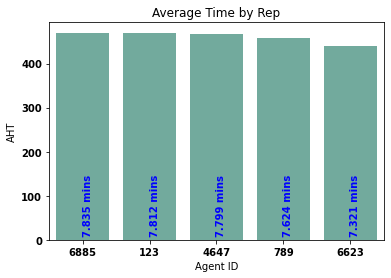

In [249]:
aht = df.groupby(by='AgentID')['Time Spent on Call (Seconds)'].mean().sort_values(ascending=False).head().reset_index()

ax = sns.barplot(
    x='AgentID', 
    y='Time Spent on Call (Seconds)', 
    data=aht, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2',
    order=df.groupby(by='AgentID')['Time Spent on Call (Seconds)'].mean().sort_values(ascending=False).head(5).index,
);

ax.set(xlabel="Agent ID", ylabel='AHT')
for i, v in enumerate(round(aht['Time Spent on Call (Seconds)']/60,3).iteritems()):        
    ax.text(i ,v[1], "{:,} mins".format(v[1]), color='b', va ='bottom', rotation=90)
plt.title("Average Time by Rep")
plt.show()

# 4. Cost per call by Primary Skill?

In [227]:
CPC = df.groupby(by='Primary Skill')['Time Spent on Call (Seconds)'].sum().reset_index()
cost_per_call = CPC.merge(numOfCall, how='inner', on=['Primary Skill'])
cost_per_call['per_call'] = cost_per_call.apply(lambda x: x['Time Spent on Call (Seconds)']/x['Transaction Number'], axis=1)
cost_per_call['Hour'] = cost_per_call['per_call'].apply(lambda x: x/60/60)
cost_per_call['COST'] = cost_per_call.Hour.apply(lambda x: x*18)
cost_per_call


,Primary Skill,Time Spent on Call (Seconds),Transaction Number,per_call,Hour,COST
0,Saves,211609,614,344.640065,0.095733,1.723200
1,Service,213556,564,378.645390,0.105179,1.893227
2,Technical Support,70120,168,417.380952,0.115939,2.086905


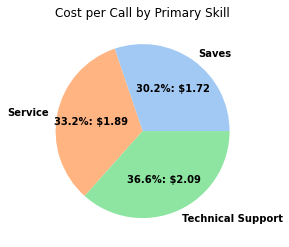

In [232]:
#define data
# dt = cost_per_call[['COST']].reset_index()
# dt = dt.iloc[:,-1]
# label = CPC[['Primary Skill']].reset_index()
# label = label.iloc[:,-1]
# # #define Seaborn color palette to use
# colors = sns.color_palette('pastel')[0:5]

# # #create pie chart
# plt.rcParams["font.weight"] = "bold"
# plt.pie(dt, labels = label,  colors = colors, autopct=lambda p : '{:.1f}%: ${:,.2f}'.format(p,p * sum(dt)/100))
# plt.title('Cost per Call by Primary Skill')
# plt.show()

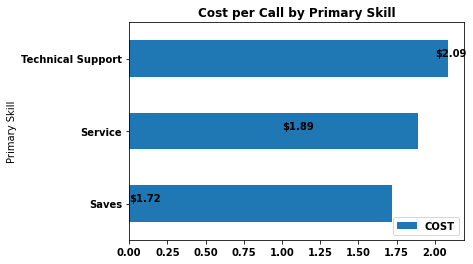

In [261]:
ax = cost_per_call[['Primary Skill', 'COST']].set_index('Primary Skill').plot.barh()
plt.title('Cost per Call by Primary Skill', fontweight='bold')

for i, v in enumerate(round(cost_per_call['COST'],2).iteritems()):
    ax.text(v[0], i  ,"${}".format(v[1]), color='k', 
                 va='bottom', rotation=0, fontweight='bold')
plt.show()

# 5. What is the average Lifetime Value, segmented by Saves vs Conversions?

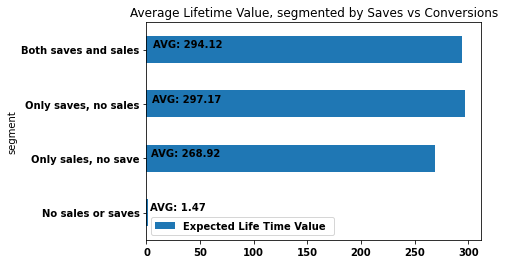

In [214]:
ltv = df.groupby(by=['Saves','Sales'])['Expected Life Time Value '].mean().reset_index()
ltv['segment'] = ltv.apply(lambda x: 'No sales or saves' if x['Saves'] == 0 and x['Sales'] == 0\
                           else  ('Only sales, no save' if x.Saves == 0 and x.Sales == 1\
                           else ('Only saves, no sales' if x.Saves == 1 and x.Sales == 0\
                           else ('Both saves and sales' if x.Saves == 1 and x.Sales == 1 else ''))) , axis=1) 
                        
ax = ltv[['segment','Expected Life Time Value ']].set_index('segment').plot.barh()
for i, v in enumerate(round(ltv['Expected Life Time Value '],2).iteritems()):
    ax.set_title('Average Lifetime Value, segmented by Saves vs Conversions')
    ax.text(v[0] + 3 , i  ,"AVG: {}".format(v[1]), color='k', 
                ha='left', va='bottom', rotation=0, fontweight='bold')

In [215]:
df.groupby(by='Primary Skill')['AgentID'].count()

Primary Skill
Saves                614
Service              564
Technical Support    168
Name: AgentID, dtype: int64

In [218]:
df.groupby(by='Primary Skill')['Transaction Number'].count()

Primary Skill
Saves                614
Service              564
Technical Support    168
Name: Transaction Number, dtype: int64